# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

#### Постановка задачи
1.1. Откройте файлы и изучите их.\
1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака `rougher.output.recovery`. Найдите `MAE` между вашими расчётами и значением признака. Опишите выводы.\
1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?\
1.4. Проведите предобработку данных.

In [1]:
# загрузка библиотек
# для осуществления операций с массивами данных
import pandas as pd
# для графического представления данных
import matplotlib.pyplot as plt
# загрузка метрики "среднее абсолютное отклонение", "среднеквадратическая ошибка"
from sklearn.metrics import mean_absolute_error, mean_squared_error
# загрузка модели линейной регрессии
from sklearn.linear_model import LinearRegression
# загрузка модели случайного леса
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
# установим максимальное количество столбцов при выводе массивов данных
pd.set_option('display.max_columns', 5)
# установим тему графической иллюстрации
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

#### 1.1. Откройте файлы и изучите их.

In [2]:
# загрузка исходной выборочной совокупности
gold_full = pd.read_csv('gold_recovery_full.csv')
# загрузка обучающего множества
gold_train = pd.read_csv('gold_recovery_train.csv')
# загрузка тестового множества
gold_test = pd.read_csv('gold_recovery_test.csv')

In [3]:
# сформируем словарь, ключами которого являются наименования, значения - статистические данные
dataframe_dict = {'исходное_мн_во':gold_full,'обучающее_мн_во':gold_train,'тестовое_мн_во':gold_test}

In [4]:
# Через цикл for осуществим
for dataframe_name, dataframe_values in dataframe_dict.items():
    # (1) вывод наименования множества
    print('----------------')
    print('*',dataframe_name)
    # (2) вывод первых 5-ти наблюдений множества
    print(dataframe_values.head())
    # (3) вывод общей информации по переменным множества
    print(dataframe_values.info())

----------------
* исходное_мн_во
                  date  final.output.concentrate_ag  ...  \
0  2016-01-15 00:00:00                     6.055403  ...   
1  2016-01-15 01:00:00                     6.029369  ...   
2  2016-01-15 02:00:00                     6.055926  ...   
3  2016-01-15 03:00:00                     6.047977  ...   
4  2016-01-15 04:00:00                     6.148599  ...   

   secondary_cleaner.state.floatbank6_a_air  \
0                                 14.151341   
1                                 13.998353   
2                                 14.028663   
3                                 14.005551   
4                                 13.996647   

   secondary_cleaner.state.floatbank6_a_level  
0                                 -605.841980  
1                                 -599.787184  
2                                 -601.427363  
3                                 -599.996129  
4                                 -601.496691  

[5 rows x 87 columns]
<class 'pan

In [5]:
# Проверим процентное соотношение между множествами
print('Обучающее / Исходное множество: {:.2f}'.format(gold_train.shape[0] / gold_full.shape[0]) )
print('Тестовое / Исходное множество {:.2f}'.format(gold_test.shape[0] / gold_full.shape[0]) )

Обучающее / Исходное множество: 0.74
Тестовое / Исходное множество 0.26


- в исходной выборочной совокупности 22 716 наблюдений, в обучающем множестве 16 860 наблюдений, в тестовом множестве 5 856 наблюдений.
- в исходном и обучающем множестве имеются 87 признаков. В тестовом множестве имеем 53 признака. Столбец с датами имеет строковый формат `object`. Все остальные переменные имеют формат с плавающей точкой `float64`.
- целевыми признаками являются `rougher.output.recovery`, `final.output.recovery`.
- наличие пропущенные наблюдений может быть обусловлено техническими причинами при заполнении.
- Статистические данные поступают с определенной периодичностью. Тем самым, методом заполнения пропущенных наблюдений может выступать интерполяция по времени посредством `.interpolate(method='time')`.

In [6]:
# Воспользуемся исключениями для того, чтобы
try:
    # через цикл for
    for dataframe in dataframe_dict.values():
        # изменить строковый формат столбца date в формат datetime
        dataframe['date'] = pd.to_datetime(dataframe['date'], format='%Y-%m-%d %H:%M:%S')
        # установить столбец date в качестве индекса множества
        dataframe = dataframe.set_index('date', inplace=True)
except:
    print('Возникла ошибка')
else:
    print('Установление индекса выполнено')

Установление индекса выполнено


#### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

In [7]:
# # Через цикл for
# for dataframe in dataframe_dict.values():
#     # Осуществим заполнение пропущенных наблюдений интеполяцией во времени
#     dataframe.interpolate(method='time', inplace=True)

In [8]:
# Определим функцию, которая вычисляет среднее абсолютное отклонение
# между фактической и расчетной эффективностью обогащения
def recovery_mae(dataframe):
    '''
    dataframe: массив данных
    output: среднее абсолютное отклонение между фактической и 
    расчетной эффективностью обогащения
    формула: ( С * (F - T) / F * (C - T) ) * 100
    '''
    # Выделим массив данных с полным набором наблюдений фактической эффективности обогащения 
    recov_no_na_subset = dataframe.dropna(subset=['rougher.output.recovery'])
    
    # Выделим вектор значений доли золота в концентрате до флотации
    F = (
        recov_no_na_subset['rougher.input.feed_au']
    )
    
    # Выделим вектор значений доли золота в концентрате после флотации
    C = (
        recov_no_na_subset['rougher.output.concentrate_au']
    )
    
    # Выделим вектор значений доли золота в отвальных хвостах
    T = (
        recov_no_na_subset['rougher.output.tail_au']
    )
    
    # Вычислим по формуле эффективность обогащения
    recovery_formula = ( (C * (F - T) ) / (F * (C - T) ) ) * 100
    # Выделим вектор фактической эффективности обогащения
    recovery_actual = dataframe['rougher.output.recovery'].dropna()
    # Вывод среднего абсолютного отклонения между расчетной и фактической эффективностью обогащения
    return mean_absolute_error(recovery_actual, recovery_formula)

In [9]:
# Апробация функции recovery_mae на тренировочное множество
recovery_mae(gold_train)

9.444891926100695e-15

- в результате, получили весьма малое среднее абсолютное отклонение ($9.4*10^{-15}$) между расчетной и фактической эффективностью обогащения

#### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [10]:
# Посредством представления списков осуществим вывод признаков
# из исходной выборочной совокупности, которые не содержатся в тестовом множестве
col_not_in_test = [col for col in gold_full.columns if col not in gold_test.columns]
col_not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

- признаки, которые отсутствуют в тестовом множестве: (1) параметры продукта `output`, (2) расчетные характеристики `calculation`.
- из параметров продуктов `output` в тестовом множестве отсутствуют: концентрат (i) серебра `concentrate_ag`, (ii) свинца `concentrate_pb`, (iii) сульфата `concentrate_sol`, (iv) золота `concentrate_au`; отвальные хвосты (a) серебра `tail_ag`, (б) свинца `tail_pb`, (в) твердых веществ `tail_sol`, (г) золота `tail_au`.
- из расчетных характеристики `calculation` в тестовом множестве отсутствуют: сульфат в исходном сырье золота `sulfate_to_au_feed`, флотационная установка 10 `floatbank_10_sulfate_to_au_feed`, флотационная установка 11 `floatbank_11_sulfate_to_au_feed`, отношение золота к свинцу `au_pb_ratio`.

#### 1.4. Проведите предобработку данных.

Осуществим заполнение пропущенных наблюдений посредством интерполяции по времени `.interpolate(method='time')`. Аргументами в пользу данного метода являются (1) временная периодичность поступления информации (каждый час), (2) состояние на последующих этапах зависит от результатов, наблюдаемых на предыдущих стадиях технологического процесса очистки.

In [11]:
# Через цикл for
for dataframe in dataframe_dict.values():
    # Осуществим заполнение пропущенных наблюдений интеполяцией во времени
    dataframe.interpolate(method='time', inplace=True)

# 2. Анализ данных

#### Постановка задачи
2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.\
2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.\
2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

#### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

Стоит отметить, что не наблюдается информация по концентрации металлов на этапе вторичной очистки `secondary_cleaner`.

In [12]:
# Определим функцию, которая выводит графическую иллюстрацию изменения концентрации металлов
# на различных этапах очистки
def plot_concentrate_hist(dataframe, stage, alpha=0.7):
    '''
    dataframe: массив данных
    stage: стадия флотации
    output: графическая иллюстрация изменения концентрации металлов
    '''
    # определим вектор концентрации серебра
    ag_concentrate = dataframe[stage+'.output.concentrate_ag']    
    # определим вектор концентрации золота
    au_concentrate = dataframe[stage+'.output.concentrate_au']
    # определим вектор концентрации свинца
    pb_concentrate = dataframe[stage+'.output.concentrate_pb']
    # объединим вектора финальной концентрации
    concentrate_df = pd.DataFrame({'серебро_концентрат':ag_concentrate,
                                   'золото_концентрат':au_concentrate,
                                   'свинец_концентрат':pb_concentrate})
    # на этапе флотации
    if stage == 'rougher':
        # выделим вектор изначальной концентрации серебра
        ag_feed = dataframe[stage+'.input.feed_ag']
        # выделим вектор изначальной концентрации золота
        au_feed = dataframe[stage+'.input.feed_au']
        # выделим вектор изначальной концентрации свинца
        pb_feed = dataframe[stage+'.input.feed_pb']
        # объединим значения изначальной концентрации металлов в единый массив
        feed_df = pd.DataFrame({'серебро_сырье':ag_feed,
                                'золото_сырье':au_feed,
                                'свинец_сырье':pb_feed})
        # определим два подграфика с равными размерностями оси абсцисс и оси ординат
        fig, axes_rougher = plt.subplots(nrows=1, ncols=2, figsize=(12,6), sharex=True, sharey=True)
        # на первом подграфике отображены плотностные гистограммы изначальной концентрации
        feed_df.plot(ax=axes_rougher[0], kind='hist', density=True, histtype='step', lw=5)
        # на втором подграфике отображены плотностные гистограммы финальной концентрации
        concentrate_df.plot(ax=axes_rougher[1],kind='hist', density=True, histtype='step', lw=5)
    # на стадии помимо флотации
    else:
        # построим плотностные гистограммы финальной концентрации металлов
        concentrate_df.plot(kind='hist', density=True, histtype='step', lw=5, label=True, figsize=(12,6))
        
    plt.tight_layout()

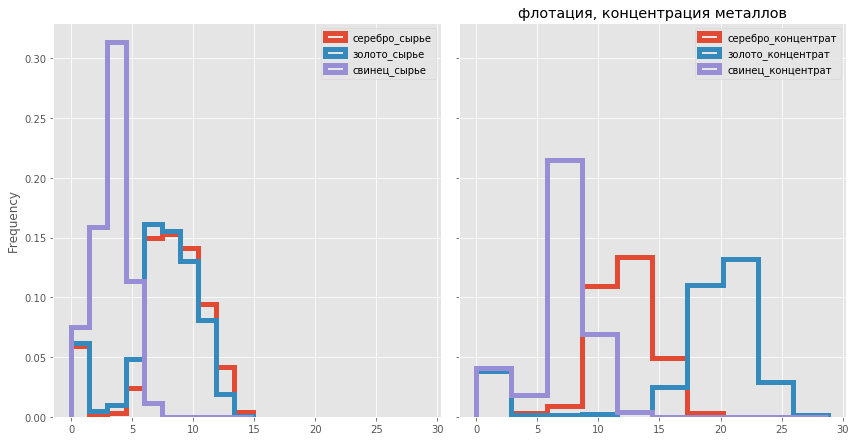

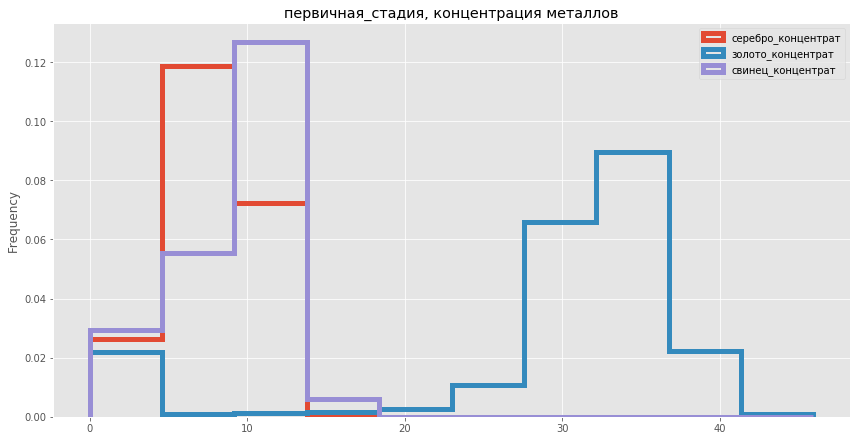

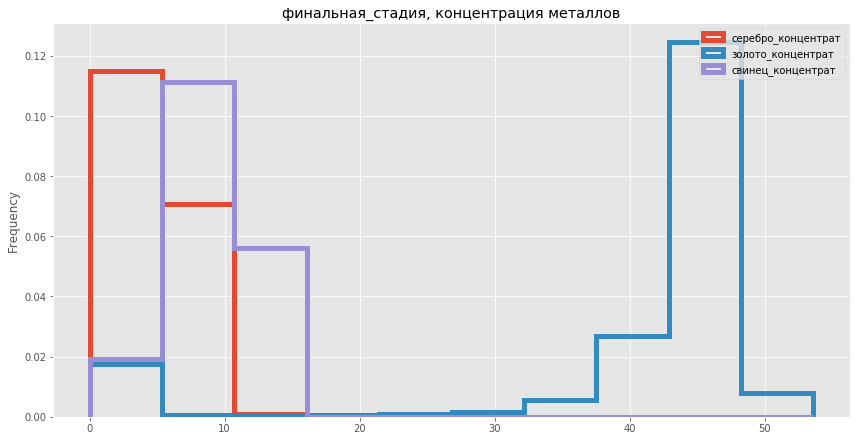

In [13]:
stage_dict = {'флотация':'rougher','первичная_стадия':'primary_cleaner','финальная_стадия':'final'}
# Через цикл for для каждой стадии очистки
for label, stage in stage_dict.items():
    # построим графическую иллюстрацию концентрации трех металлов (серебра, золота и свинца)
    plot_concentrate_hist(gold_full, stage)
    # определим заголовок диаграмм
    plt.title(label+', концентрация металлов')
    # отображение диаграмм
    plt.show()

- наблюдаем значительное изменение изначальной концентрации металлов после флотации (что видно на первых двух  подграфиках).
- на каждой из трех стадий наибольшую долю концентрации имеет золото. Серебро и свинец имеют приблизительно одинаковую концентрацию.

#### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

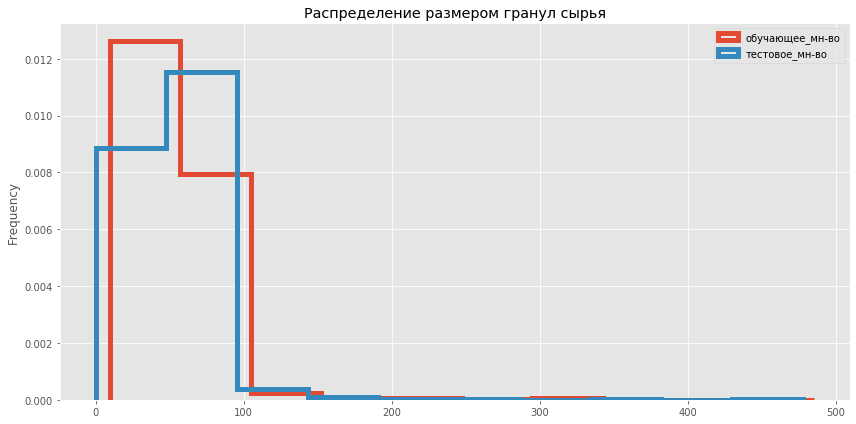

In [14]:
# Построим плотностную гистограмму распределения гранул сырья
# (1) на обучающем множестве
ax = gold_train['rougher.input.feed_size'].plot(kind='hist', density=True, figsize=(12,6),
                                                histtype='step', lw=5, label='обучающее_мн-во')
# (2) на тестовом множестве
gold_test['rougher.input.feed_size'].plot(ax=ax, kind='hist', density=True, 
                                          histtype='step', lw=5, label='тестовое_мн-во')
# зададим заголовок диаграммы
plt.title('Распределение размером гранул сырья')
# отображение легенды
plt.legend()
plt.tight_layout()

- распределение размеров гранул сырья на обучающей и тестовой выборках сильно не отличаются.
- б*о*льшая часть размеров гранул концентрировано в диапазоне от 0 до 100
- имеет место тяжелый правый хвост плотностного распределения как в обучающем, так и в тестовом выборках.

#### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [15]:
# Определим функцию, которая отображает графическую иллюстрацию (ящик с усами или гистограмму) 
# для всех веществ на разных стадиях
def plot_concentrate_box_or_hist(dataframe, stage, plot_kind='box', bins=None, alpha=1):
    '''
    dataframe: массив данных
    stage: стадия технологического процесса (rougher, final)
    plot_kind: тип графической иллюстрации (box ящик с усами, hist гистограмма)
    bins: количество разбиений (интервалов) гистограммы распределения
    alpha: степень прозрачности графиков
    output: ящик с усами для всех веществ на разных стадиях
    '''
    # определим вектор концентрации серебра
    ag_concentrate = dataframe[stage+'.output.concentrate_ag']    
    # определим вектор концентрации золота
    au_concentrate = dataframe[stage+'.output.concentrate_au']
    # определим вектор концентрации свинца
    pb_concentrate = dataframe[stage+'.output.concentrate_pb']
    # определим вектор концентрации твердых веществ
    sol_concentrate = dataframe[stage+'.output.concentrate_sol']
    # объединим вектора финальной концентрации
    concentrate_df = pd.DataFrame({'серебро':ag_concentrate,
                                   'золото':au_concentrate,
                                   'свинец':pb_concentrate,
                                   'твердые_вещества':sol_concentrate})
    # если этап флотации
    if stage == 'rougher':              
        # выделим вектор изначальной концентрации серебра
        ag_feed = dataframe[stage+'.input.feed_ag']
        # выделим вектор изначальной концентрации золота
        au_feed = dataframe[stage+'.input.feed_au']
        # выделим вектор изначальной концентрации свинца
        pb_feed = dataframe[stage+'.input.feed_pb']
        # выделим вектор изначальной концентрации твердых веществ
        sol_feed = dataframe[stage+'.input.feed_sol']
        # объединим значения изначальной концентрации металлов в единый массив
        feed_df = pd.DataFrame({'серебро':ag_feed,
                                'золото':au_feed,
                                'свинец':pb_feed,
                                'твердые_вещества':sol_feed})
        # построим ящик с усами
        if plot_kind == 'box':
            # (1) для изначальной концентрации веществ
            feed_df.plot(kind=plot_kind, vert=False, 
                         figsize=(12,6)).set(title='изначальный_концентрат')
            # (2) для черновой концентрации веществ
            concentrate_df.plot(kind=plot_kind, vert=False, figsize=(12,6)).set(title='черновой_концентрат')
        # построим гистограммы
        elif plot_kind == 'hist':
            # (1) для изначальной концентрации веществ
            feed_df.plot(kind=plot_kind, bins=bins, histtype='step', lw=5, alpha=alpha,
                         figsize=(12,6)).set(title='изначальный_концентрат')
            # (2) для черновой концентрации веществ
            concentrate_df.plot(kind=plot_kind, bins=bins, histtype='step', lw=5,alpha=alpha,
                                figsize=(12,6)).set(title='черновой_концентрат')
    # если этап финальных характеристик
    elif stage == 'final':
        # построим ящик с усами для финальной концентрации веществ
        if plot_kind == 'box':
            concentrate_df.plot(kind=plot_kind, vert=False, figsize=(12,6)).set(title='финальный_концентрат')
        # построим гистограмму финальной концентрации веществ
        elif plot_kind == 'hist':
            concentrate_df.plot(kind=plot_kind, bins=bins, histtype='step', lw=5,alpha=alpha,
                                figsize=(12,6)).set(title='финальный_концентрат')
    plt.tight_layout()

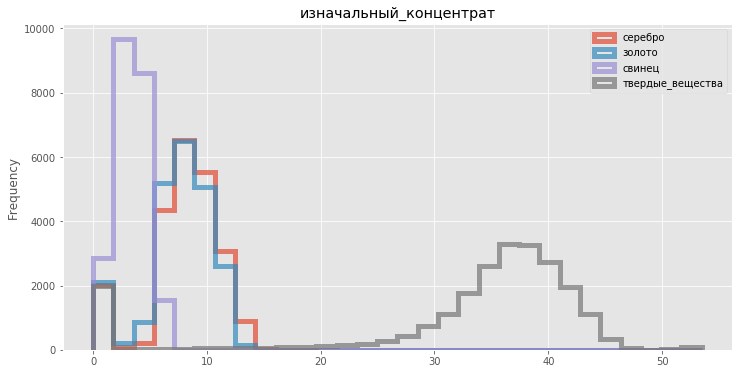

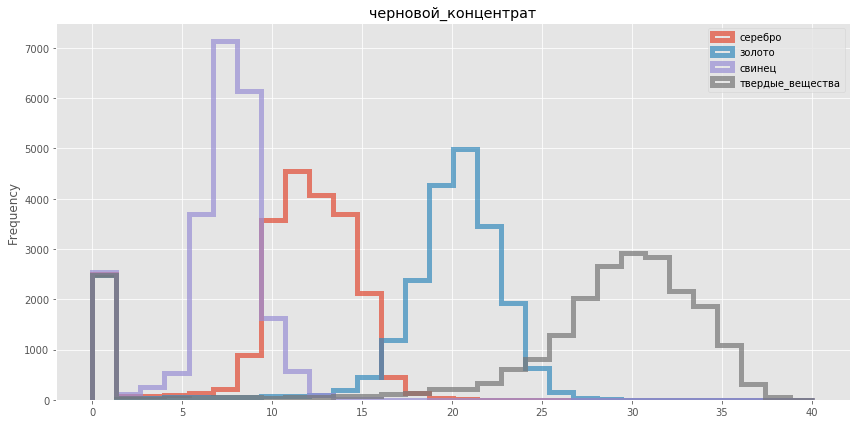

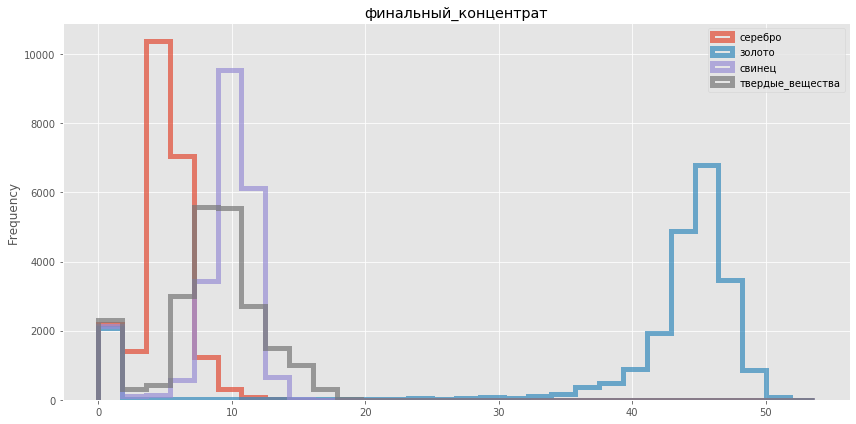

In [16]:
# Через цикл for для каждой стадии очистки
for stage in ['rougher','final']:
    # построим гистограммы концентрации всех веществ (серебро, золото, свинец, твердые вещества)
    plot_concentrate_box_or_hist(gold_full, stage, 'hist', bins=30, alpha=0.7)
    # отображение диаграмм
    plt.show()

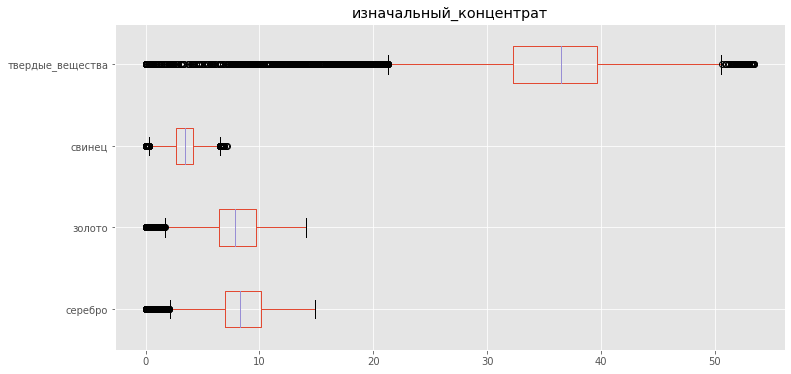

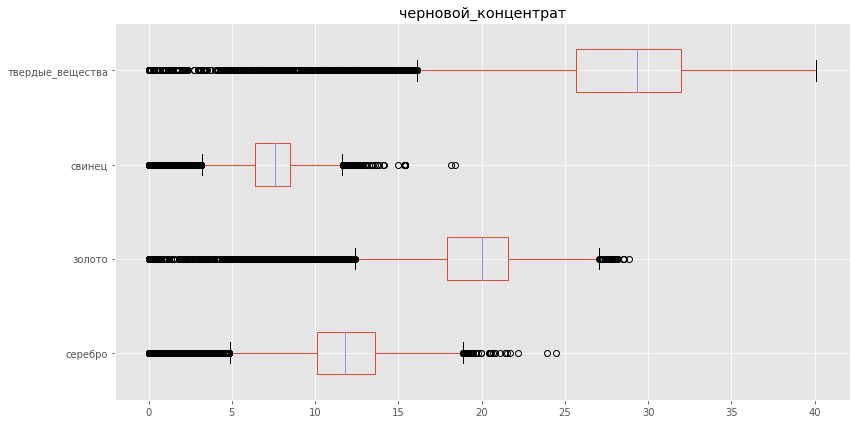

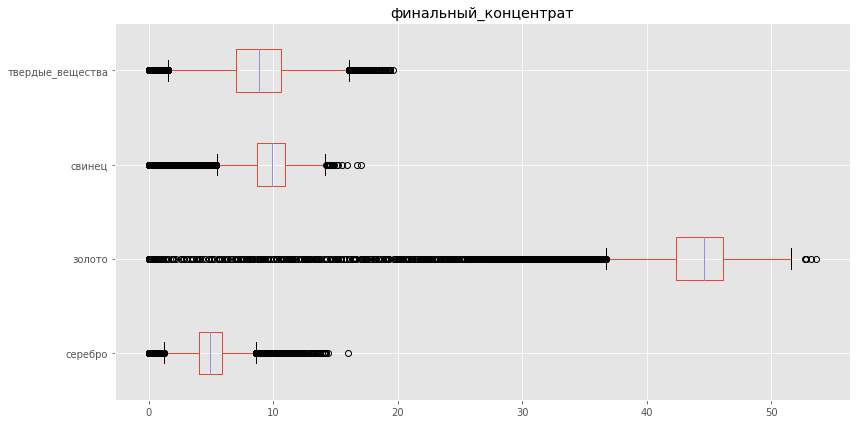

In [17]:
# Через цикл for для каждой стадии очистки
for stage in ['rougher','final']:
    # построим ящик с усами для концентрации всех веществ (серебро, золото, свинец, твердые вещества)
    plot_concentrate_box_or_hist(gold_full, stage, 'box')
    # отображение диаграмм
    plt.show()

- на этапе изначального концентрата наблюдается редкие концентрации твердых веществ, превышающие 51 процент.
- в отношении остальных веществ, как свинец, серебро, амплитуда значений не столь высокая.
- наличие большой доли твердых веществ на этапе изначальной концентрации весьма оправдано, так как на первичных стадиях технологической очистки поступают сырье, содержащее множество веществ помимо свинца, золота и серебра.
- на этапе финальной концентрации наблюдаются несколько редких величин концентрации золота, превышающие чуть больше 50 процентов. Вычислим долю данных редких наблюдений.

In [18]:
# вычислим долю редких наблюдений финальной концентрации золота в тренировочном множестве
gold_train.loc[gold_train['final.output.concentrate_au'] > 50, :].shape[0] / len(gold_train) * 100

0.4033214709371293

In [19]:
# вычислим долю редких наблюдений финальной концентрации золота в исходной выборочной совокупности
gold_full.loc[gold_full['final.output.concentrate_au'] > 50, :].shape[0] / len(gold_full) * 100

0.44462053178376476

- Доля редких наблюдений финальной концентрации золота в контексте тренировочного множества составляет около 0.4 процента. В контексте исходной выборки: 0.44 процента. Удаление данных наблюдений скорее не приведут к смещению результатов последующего анализа. Тем самым, сохраняем имеющиеся данные в прежнем виде.

Количество интервалов составляет 30. Согласно гистограммам:
- у всех веществ (серебро, золото, свинец, твердые вещества) наблюдается "горб" на всех этапах концентрации (изначальный, черновой, финальный) в интервале **от 0 до 2** процентов. Тем самым, удалим данный "горб".
- *распределения концентрации твердых веществ*: (1) левый тяжелый хвост на этапе изначального и чернового концентрата, (2) правый тяжелый хвост на этапе финального концентрата;
- *распределение концентрации свинца*: правый тяжелый хвост на этапе изначального и чернового концентрата
- *распредедение концентрации золота*: левый тяжелый хвост на этапе финального концентрата.


In [20]:
# Определим функцию, которая сохраняет значения превышающие указанный пороговый уровень
def del_outliers(dataframe, stage=stage, substance='concentrate_au', threshold=2):
    '''
    dataframe: массив данных
    stage: этап (изначальный rougher.input, черновой rougher.output, финальный final.output)
    substance: вещество - (1) серебро feed_ag, concentrace_ag, (2) свинец feed_pb, concentrate_pb
    (3) золото feed_au, concentrate_au, (4) твердые вещества feed_sol, concentrate_sol
    threshold: пороговый уровень (сохраняются значения справа от указанного уровня)
    output: массив данных, сохраняющие значения, которые превышают пороговый уровень
    '''
    return dataframe.loc[dataframe[stage+'.'+substance] > threshold,:]

In [21]:
# Через цикл for на этапе исходной концентрации
for feed in ['feed_ag','feed_au','feed_pb','feed_sol']:
    # оставим те значения концентрации веществ, которые больше двух процентов
    gold_train_no_outliers = del_outliers(gold_train, stage='rougher.input', substance=feed)

In [22]:
# Через цикл for на этапе черновой и финальной концентрации
for output in ['rougher.output','final.output']:
    # аналогично, оставим те значения концентрации веществ, которые больше двух процентов
    for concentrate in ['concentrate_ag','concentrate_au','concentrate_pb','concentrate_sol']:
        gold_train_no_outliers = del_outliers(gold_train_no_outliers, stage=output, substance=concentrate)

# 3. Модель

#### Постановка задачи
3.1. Напишите функцию для вычисления итоговой sMAPE.\
3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

In [23]:
# Определим функцию sMAPE, которая вычисляет симметричное среднее абсолютное процентное отклонение
def sMAPE(target, predictions):
    '''
    target: фактические величины целевого признака 
    predictions: прогнозные величины целевого признака
    '''
    # определим числитель результирующего параметра
    smape_numerator = abs(target - predictions)
    # определим знаменатель результирующего параметра
    smape_denominator = ( (abs(target) + abs(predictions)) / 2)
    # находим сумму отношений числителя к знаменателю
    ratio = (smape_numerator / smape_denominator).sum()
    # вывод результирующего параметра - симметричное среднее абсолютное процентное отклонение
    return (ratio / len(target) ) * 100

In [24]:
# выделение матрицы характеристик
features = gold_train_no_outliers.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
# выделение целевых признаков
target = gold_train_no_outliers[['rougher.output.recovery','final.output.recovery']]

In [25]:
# Определим функцию, которая возвращает оптимальную модель случайного леса
def opt_rf_search(features, target, max_depth=[10,15], n_estimators=[120,130], cv=3):
    '''
    features: матрица характеристик
    target: целевой признак
    max_depth: максимальная глубина деревьев
    n_estimators: количество деревьев в лесу
    cv: количество блоков перекрестной кросс-валидации
    output: оптимальные гиперпараметры модели
    '''
    # разделим матрица характеристик и вектор целевого признака на обучающее и валидационное мн-ва, соответственно.
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=0.25,
                                                                                  random_state=42)
    # Установление гиперпараметров
    params = {'max_depth': max_depth, 'n_estimators': n_estimators}
    # Инициализация моделей случайного леса
    grid_obj = GridSearchCV(estimator=RandomForestRegressor(random_state=42, n_jobs=-1), 
                      param_grid=params, cv=cv, scoring='neg_mean_squared_error') 
    # Обучение моделей случайного леса
    rf_grid = grid_obj.fit(features_train, target_train)
    # вывод оптимальных (1) характеристик, (2) гиперпараметров модели случайного леса
    return rf_grid.best_estimator_, rf_grid.best_params_

In [26]:
# игнорирование FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
# Поиск оптимальных гиперпараметров модели случайного леса
rf_best_est, rf_best_params = opt_rf_search(features, target)

In [27]:
# вывод оптимальных характеристик модели случайного леса
rf_best_est

RandomForestRegressor(max_depth=15, n_estimators=130, n_jobs=-1,
                      random_state=42)

In [28]:
# вывод оптимальных гиперпараметров модели случайного леса
rf_best_params

{'max_depth': 15, 'n_estimators': 130}

зафиксируем оптимальные гиперпараметры для вычисления прогнозных значений на основе тестового множества.

In [29]:
# Инициализация оптимальной модели случайного леса
opt_rf_model = RandomForestRegressor(random_state=42, max_depth=15, n_estimators=130, n_jobs=-1)

In [30]:
# Выделение матрицы целевого признака
test_target = (
    # Для этого, соединим по индексам тестовое множество
    gold_test\
    # с исходной выборкой
    .join(gold_full, how='left', lsuffix='_test',rsuffix='_full')\
    # и выделим черновой и финальный концентраты золота
    [['rougher.output.recovery','final.output.recovery']]
)

In [31]:
# Отбор тех показателей, которые имеются как в обучающем, так и в тестовом множествах
train_and_test_cols = [col for col in gold_train.columns if col in gold_test.columns]

In [32]:
# Определим функцию, которая возвращает
# (1) таблицу, содержащую квадрат среднеквадратической ошибки (с т.з. scoring) на основе тренировочного множества
# (2) прогнозные значения модели на основе тестового множества
def model_rmse_and_pred(model, features, target, test_dataframe, cv=3):
    '''
    model: оптимальная модель машинного обучения
    features: массив характеристик
    target: целевые признаки 
    cv: количество разбиений кросс-валидации
    '''
    # разделим матрица характеристик и вектор целевого признака на обучающее и валидационное мн-ва, соответственно.
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=0.25,
                                                                                  random_state=42)
    # вычисление прогнозных значений на основе тестового множества
    model_pred = (
        model\
        .fit(features_train[train_and_test_cols], target_train)\
        .predict(test_dataframe)
    )
    # Осуществим кросс-валидацию
    model_cross_val = cross_val_score(estimator=model, X=features_train[train_and_test_cols], y=target_train,
                                      cv=cv, scoring='neg_mean_squared_error')
    # вывод таблицы, содержащей квадратный корень среднеквадратического отклонения в зависимости от
    # количества разбиений кросс-валидации
    rmse_dataframe = pd.DataFrame({'cv':list(range(1,cv+1)),'rmse': (-model_cross_val) ** 0.5} )
    #
    return rmse_dataframe, model_pred

In [33]:
# Апробация функции model_rmse_and_pred на модель линейной регрессии
lin_cv_rmse, lin_pred = model_rmse_and_pred(LinearRegression(n_jobs=-1), features, target, gold_test)

In [34]:
# Апробация функции model_rmse_and_pred на модель случайного леса
opt_rf_cv_rmse, opt_rf_pred = model_rmse_and_pred(opt_rf_model, features, target, gold_test)

In [35]:
# Подсчитаем среднее значение квадратного корня среднеквадратической ошибки по трем блокам кросс-валидации
# (1) для модели линейной регрессии, (2) для модели случайного леса
round(
    lin_cv_rmse\
    .merge(opt_rf_cv_rmse, on='cv', suffixes=['_lin','_rf'])\
    .set_index('cv')\
    .mean(),2
)

rmse_lin    7.04
rmse_rf     5.46
dtype: float64

Тем самым, модель случайного леса по трем блокам кросс-валидации лучше модели линейной регрессии. Таким образом, выбираем модель случайного леса с параметрами `max_depth=15`, `n_estimators=150`.

In [36]:
# Определим функцию, которая вывод квадратный корень среднеквадратической ошибки
# между фактическими значениями и (1) прогнозными по модели машинного обучения,
# (2) средними величинами константной модели
def compare_with_const_model(predictions, target):
    '''
    predictions: прогнозные значения на основе модели машинного обучения
    features: матрица характеристик
    target: матрица целевого признака
    output: массив данных, который содержит результаты моделей
    машинного обучения и константной модели в зависимости от указанной метрики
    '''
    # фактические величины чернового концентрата золота
    actual_rougher = target['rougher.output.recovery']
    # фактические величины финального концентрата золота
    actual_final = target['final.output.recovery']
    # прогнозные величины черного концентрата золота
    pred_rougher = predictions[:,0]
    # прогнозные величины финального концентрата
    pred_final = predictions[:,1]
    # вектор средних значений чернового концентрата золота
    mean_rougher = pd.Series(data=actual_rougher.mean(), index=actual_rougher.index)
    # вектор средних значений финального концентрата золота
    mean_final = pd.Series(data=actual_final.mean(), index=actual_final.index)
    # корень среднеквадратической ошибки между
    # (1) фактическими и прогнозными величинами чернового концентрата золота
    rmse_actual_pred_rougher = mean_squared_error(actual_rougher, pred_rougher) ** 0.5
    # (2) фактическими и прогнозными величинами финального концентрата золота
    rmse_actual_pred_final = mean_squared_error(actual_final, pred_final) ** 0.5
    # (3) фактическими и средними величинами чернового концентрата золота
    rmse_actual_mean_rougher = mean_squared_error(actual_rougher, mean_rougher) ** 0.5
    # (4) фактическими и средними величинами финального концентрата золота
    rmse_actual_mean_final = mean_squared_error(actual_final, mean_final) ** 0.5
    # вывод результирующих показателей
    return {
        'факт_прогноз_чернового_концентрата':round(rmse_actual_pred_rougher,2), # 
        'факт_среднее_чернового_концентрата':round(rmse_actual_mean_rougher,2), # 
        'факт_прогноз_финального_концентрата':round(rmse_actual_pred_final,2),  # 
        'факт_среднее_финального_концентрата':round(rmse_actual_mean_final,2)   # 
    }  

In [37]:
# Сравним квадратный корень среднеквадратической ошибки
# (1) модели случайного леса, (2) константной модели (среднее значение фактических величин целевого признака)
compare_with_const_model(opt_rf_pred, test_target)

{'факт_прогноз_чернового_концентрата': 13.75,
 'факт_среднее_чернового_концентрата': 13.55,
 'факт_прогноз_финального_концентрата': 12.17,
 'факт_среднее_финального_концентрата': 14.59}

- *черновой концентрат*: модель случайного леса немного отстает от константной модели.
- *финальный концентрат*: модель случайного леса лучше константной модели.

In [38]:
smape_rougher = sMAPE(test_target['rougher.output.recovery'], opt_rf_pred[:,0])
smape_final = sMAPE(test_target['final.output.recovery'], opt_rf_pred[:,1])
smape = 0.25 * smape_rougher + 0.75 * smape_final
print('среднее абсолютное процентное отклонение составляет {:.3f}'.format(smape))

среднее абсолютное процентное отклонение составляет 13.393
